## Objective
Examine some examples of model predictions on data

In [1]:
%load_ext autoreload
%autoreload

# Update PATH to allow imports
import sys
sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import numpy as np
from src.model import ModelSpikeSorter
from src.utils import random_seed
from src import data, meta

In [2]:
MODEL_PATH = meta.SI_MODELS[2]

In [3]:
model = ModelSpikeSorter.load(MODEL_PATH)

random_seed(231)
cross_val = data.RecordingCrossVal(
    samples_per_waveform=2, front_buffer=model.buffer_front_sample, end_buffer=model.buffer_end_sample,
    num_wfs_probs=[0, 0, 0, 0, 1],
    isi_wf_min=3, isi_wf_max=None,
    rec_paths=meta.SI_MOUSE[:], thresh_amp=36,
    thresh_std=0.6,
    sample_size=model.sample_size, start=0, ms_before=3, ms_after=3, gain_to_uv=meta.GAIN_TO_UV,
    device="cuda", dtype=torch.float16, mmap_mode="r",
    as_datasets=False,
    num_workers=0, shuffle=True, batch_size=1
)

rec, train, val = cross_val[2]
val_dataset = val.dataset

Using random seed 231


In [117]:
npz = np.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320/sorted.npz", allow_pickle=True)

Using random seed 1150


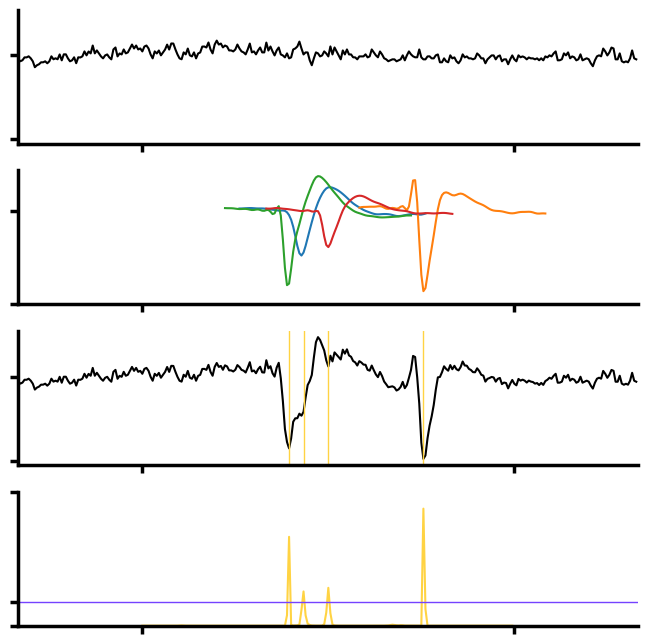

Model predictions: [131 138 150 196]


In [131]:
# Create 4-waveform example 
wf_locs=[137, 195, 130, 150]  
peak_idx=30  # Peak idx of templates
unit_ind=[40, 5, 11, 23]  # 160, 23, 2
temp_ind=[3, 8, 4, 4]  # Sorted decending

XTICKS = [60, 240]
XLIM = [0, 300]
YTICKS_PERCENT = [0, 17.5, 100]
YTICKS_UV = [0, -200]

from pathlib import Path
SVG_PATH = "/data/MEAprojects/RT-Sort/figures/supplementary/spike_detection_model_for_artificially_generated_samples/example_preds/4_waveforms.svg"
SVG_PATH = Path(SVG_PATH)
TICKS_PATH = SVG_PATH.parent / f"{SVG_PATH.name.split('.')[0]}_ticks.txt"  # Where to save ticks
SVG_PATH.parent.mkdir(exist_ok=True, parents=True)

random_seed(1150)
##
fig, axes = plt.subplots(4, 1, figsize=(8, 8))
a0, a1, a2, a3 = axes

noise = val.dataset.recs[0].get_sample()
a0.plot(noise - np.median(noise), color="black")

templates = []
for unit_idx, temp_idx in zip(unit_ind, temp_ind):
    unit = npz['units'][unit_idx]
    sorted_ind = np.argsort(-unit['amplitudes'])
    # print(unit['amplitudes'][temp_ind[temp_idx]] / meta.GAIN_TO_UV)
    templates.append(unit['template'][30:, sorted_ind[temp_idx]])
for temp, loc in zip(templates, wf_locs):
    x = np.arange(temp.size) - peak_idx
    x += loc
    a1.plot(x, temp)

for wf, loc in zip(templates, wf_locs):
    val_dataset.add_wf_to_trace(noise, wf, peak_idx, len(wf), round(loc))

noise -= np.median(noise)

a2.plot(noise, color="black")

sample = torch.tensor(noise, dtype=torch.float32, device="cpu")[None, None, :]
with torch.no_grad():
    model = model.to(dtype=torch.float32, device="cpu")
    outputs = model(sample)
    preds = model.outputs_to_preds(outputs)[0]
    outputs = 1/(1+np.exp(-outputs.flatten().cpu().numpy())) * 100
for loc in preds:
    a2.axvline(loc, color="#ffd343", linewidth=1)

a3.plot(np.arange(outputs.size) + model.buffer_front_sample, outputs, color="#ffd343")
a3.axhline(model.get_loc_prob_thresh(), color="#7542ff", linewidth=1)
a3.set_ylim(0, 100)

for ax in axes:
    ax.set_xlim(0, 200)
    
    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Increase thickness of the bottom and left spines
    ax.spines["bottom"].set_linewidth(2.5)
    ax.spines["left"].set_linewidth(2.5)

    # Increase thickness of tick marks
    ax.tick_params(axis='both', direction='out', length=6, width=2.5, colors='black')

    # Hide labels
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    # Update ticks
    if XTICKS is not None:
        ax.set_xticks(XTICKS, [''] * len(XTICKS))
        if XLIM is None:
            ax.set_xlim(XTICKS[0], XTICKS[-1])
        else:
            ax.set_xlim(*XLIM)
        ax.set_yticks([])

ylim = a2.get_ylim()
a0.set_ylim(ylim)
a3.set_yticks(YTICKS_PERCENT, [''] * len(YTICKS_PERCENT))
for ax in (a0, a1, a2):
    ax.set_yticks(YTICKS_UV, [''] * len(YTICKS_UV))

# Save figure
plt.savefig(SVG_PATH, format="svg")
# Save ticks
with open(TICKS_PATH, "w") as file:
    file.write(f"x-ticks: {XTICKS} frames\ny-ticks for 1st, 2nd, 3rd plots: {YTICKS_UV} microvolts\ny-ticks for last plot: {YTICKS_PERCENT}%")

plt.show()

print(f"Model predictions: {preds}")

Using random seed 501


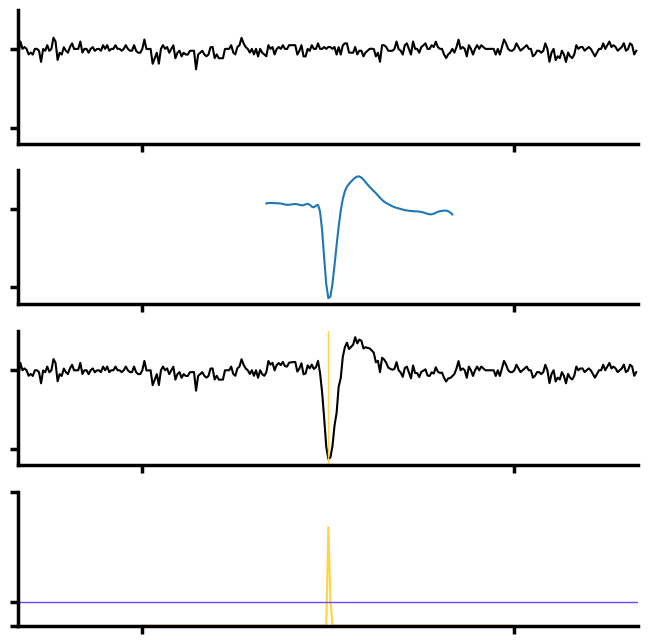

Model predictions: [150]


In [137]:
# Create 1-waveform example 
wf_locs=[150]
peak_idx=30  # Peak idx of templates
unit_ind=[3]
temp_ind=[3]  # Sorted by decending amplitude

XTICKS = [60, 240]
XLIM = [0, 300]
YTICKS_PERCENT = [0, 17.5, 100]
YTICKS_UV = [0, -100]

from pathlib import Path
SVG_PATH = "/data/MEAprojects/RT-Sort/figures/supplementary/spike_detection_model_for_artificially_generated_samples/example_preds/1_waveforms.svg"
SVG_PATH = Path(SVG_PATH)
TICKS_PATH = SVG_PATH.parent / f"{SVG_PATH.name.split('.')[0]}_ticks.txt"  # Where to save ticks
SVG_PATH.parent.mkdir(exist_ok=True, parents=True)

random_seed(501)
##
fig, axes = plt.subplots(4, 1, figsize=(8, 8))
a0, a1, a2, a3 = axes

noise = val.dataset.recs[0].get_sample()
a0.plot(noise - np.median(noise), color="black")

templates = []
for unit_idx, temp_idx in zip(unit_ind, temp_ind):
    unit = npz['units'][unit_idx]
    sorted_ind = np.argsort(-unit['amplitudes'])
    # print(unit['amplitudes'][temp_ind[temp_idx]] / meta.GAIN_TO_UV)
    templates.append(unit['template'][30:, sorted_ind[temp_idx]])
for temp, loc in zip(templates, wf_locs):
    x = np.arange(temp.size) - peak_idx
    x += loc
    a1.plot(x, temp)

for wf, loc in zip(templates, wf_locs):
    val_dataset.add_wf_to_trace(noise, wf, peak_idx, len(wf), round(loc))

noise -= np.median(noise)

a2.plot(noise, color="black")

sample = torch.tensor(noise, dtype=torch.float32, device="cpu")[None, None, :]
with torch.no_grad():
    model = model.to(dtype=torch.float32, device="cpu")
    outputs = model(sample)
    preds = model.outputs_to_preds(outputs)[0]
    outputs = 1/(1+np.exp(-outputs.flatten().cpu().numpy())) * 100
for loc in preds:
    a2.axvline(loc, color="#ffd343", linewidth=1)

a3.plot(np.arange(outputs.size) + model.buffer_front_sample, outputs, color="#ffd343")
a3.axhline(model.get_loc_prob_thresh(), color="#7542ff", linewidth=1)
a3.set_ylim(0, 100)

for ax in axes:
    ax.set_xlim(0, 200)
    
    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Increase thickness of the bottom and left spines
    ax.spines["bottom"].set_linewidth(2.5)
    ax.spines["left"].set_linewidth(2.5)

    # Increase thickness of tick marks
    ax.tick_params(axis='both', direction='out', length=6, width=2.5, colors='black')

    # Hide labels
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    # Update ticks
    if XTICKS is not None:
        ax.set_xticks(XTICKS, [''] * len(XTICKS))
        if XLIM is None:
            ax.set_xlim(XTICKS[0], XTICKS[-1])
        else:
            ax.set_xlim(*XLIM)
        ax.set_yticks([])

ylim = a2.get_ylim()
a0.set_ylim(ylim)
a3.set_yticks(YTICKS_PERCENT, [''] * len(YTICKS_PERCENT))
for ax in (a0, a1, a2):
    ax.set_yticks(YTICKS_UV, [''] * len(YTICKS_UV))

# Save fig
plt.savefig(SVG_PATH, format="svg")
# Save ticks
with open(TICKS_PATH, "w") as file:
    file.write(f"x-ticks: {XTICKS} frames\ny-ticks for 1st, 2nd, 3rd plots: {YTICKS_UV} microvolts\ny-ticks for last plot: {YTICKS_PERCENT}%")

plt.show()

print(f"Model predictions: {preds}")


In [ ]:
wf_locs = [2.8*20, 3.7*20, 3.9*20, 4.3*20]
for wf, loc in zip(templates, wf_locs):
    val_dataset.add_wf_to_trace(noise, wf, 20, len(wf), loc)


In [49]:
# npz = np.load("/data/MEAprojects/DLSpikeSorter/data/2954/sorted.npz", allow_pickle=True)
# for i, unit in enumerate(npz["units"]):
#     print(i, np.max(np.abs(unit['amplitudes'])) / meta.GAIN_TO_UV)
    
for u, unit in enumerate(npz['units']):
    for a, amp in enumerate(sorted(unit['amplitudes'], reverse=True)):
        amp = amp / meta.GAIN_TO_UV
        if np.abs(amp - 5.59) <= 0.1:
            print(u,a,amp)

npz = np.load("/data/MEAprojects/DLSpikeSorter/data/2954/sorted.npz", allow_pickle=True)

5 1 5.591372554967083
7 3 5.57023618969105
23 0 5.574841644593776
24 0 5.559168310044572


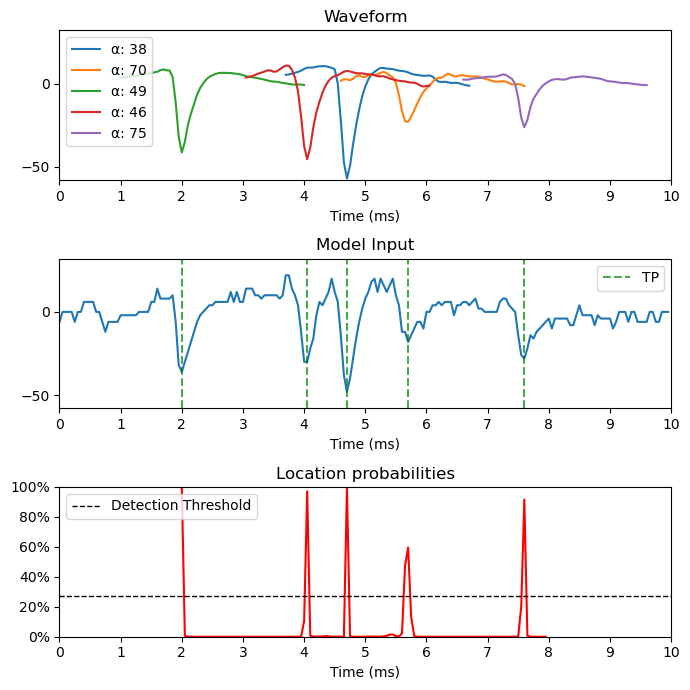

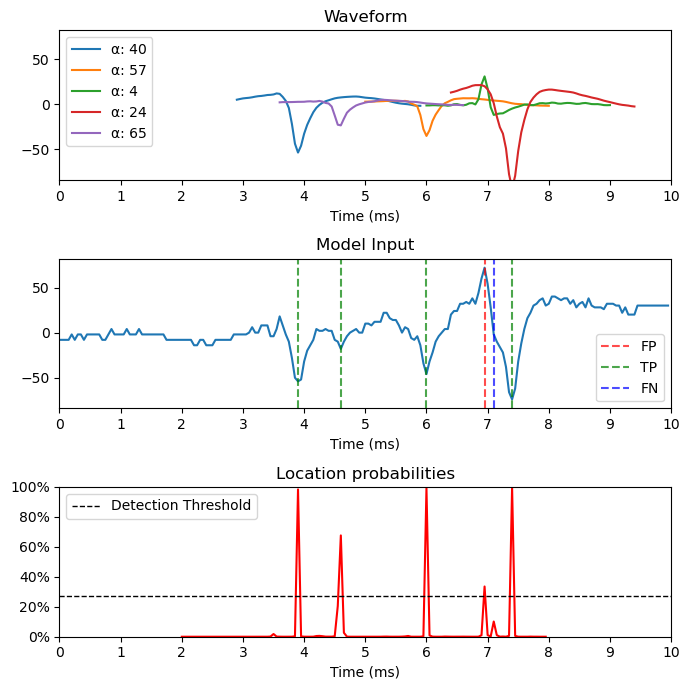

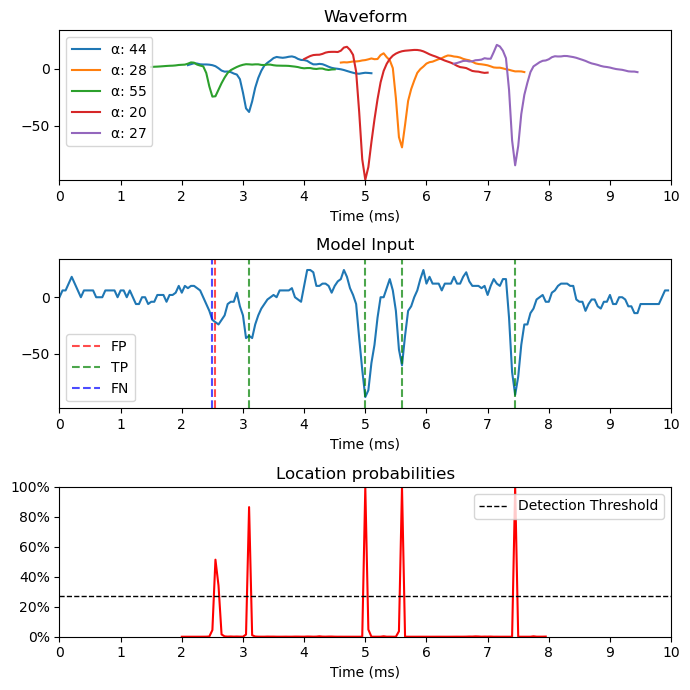

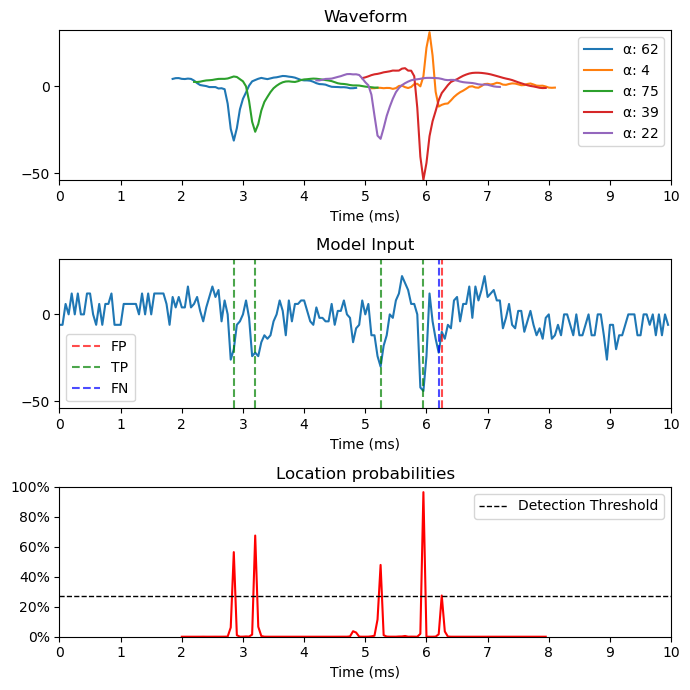

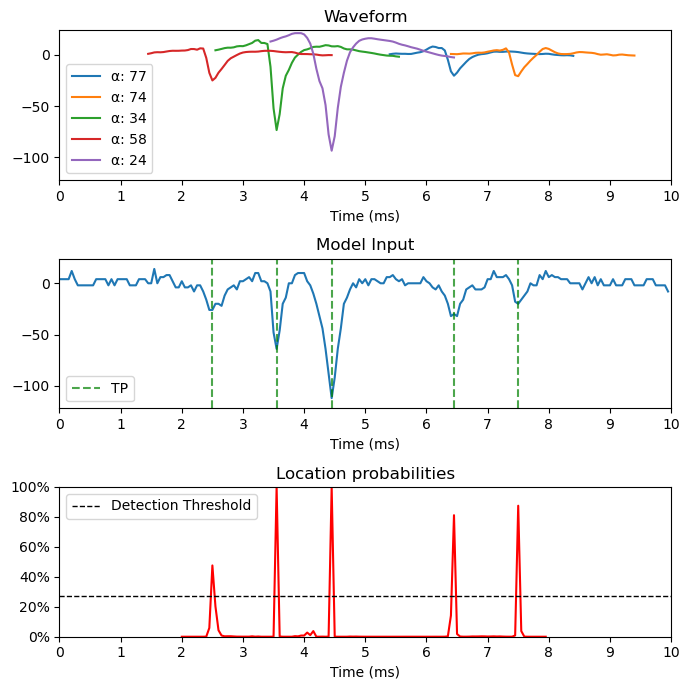

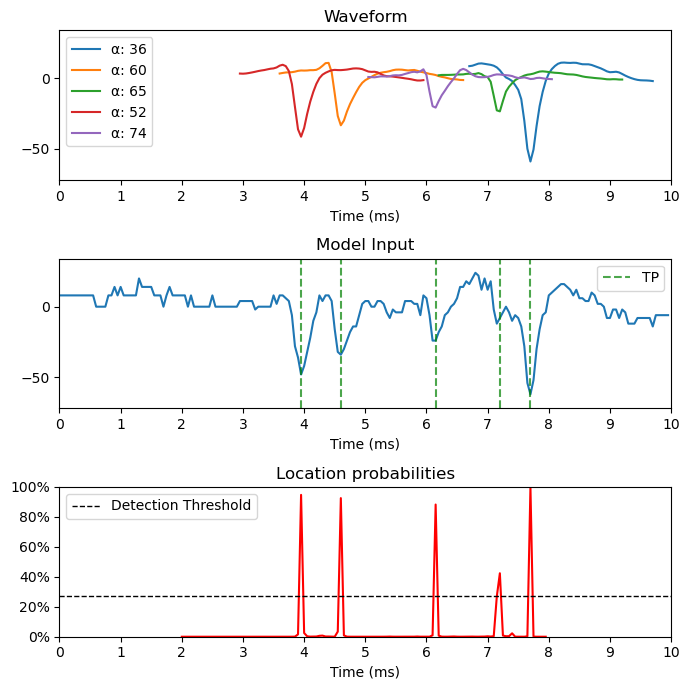

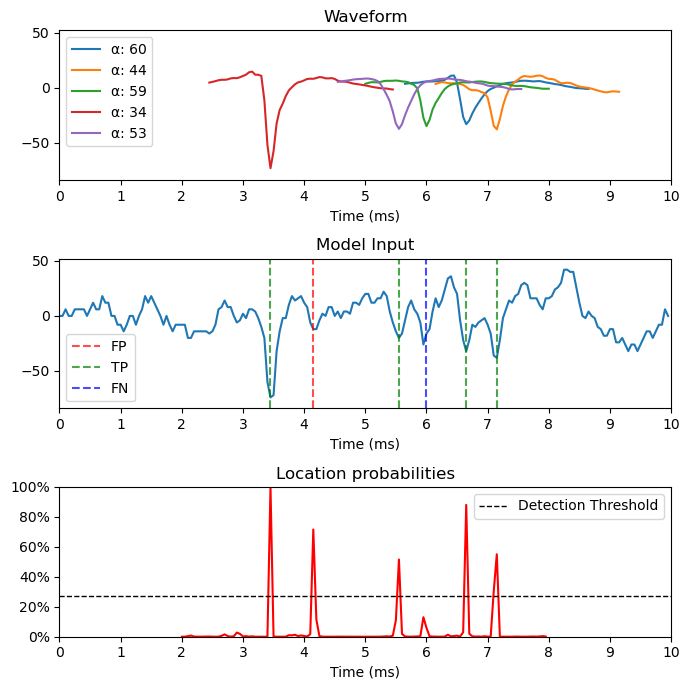

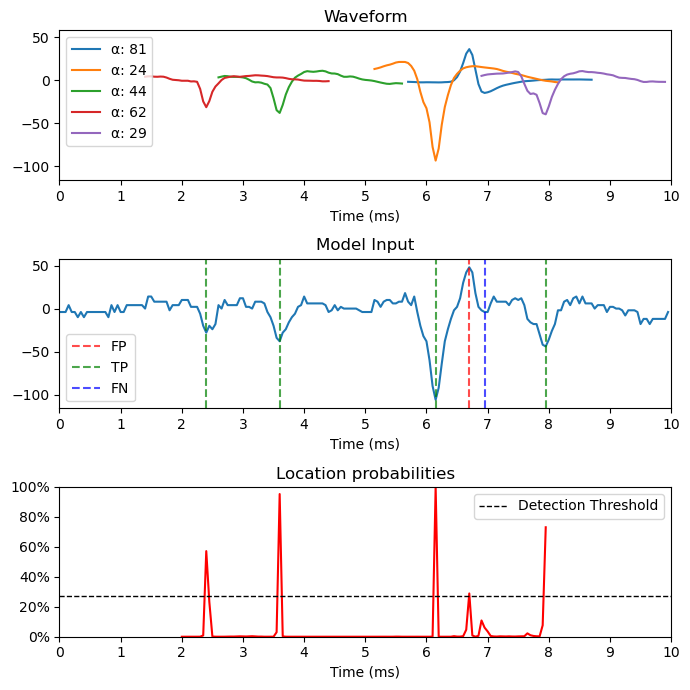

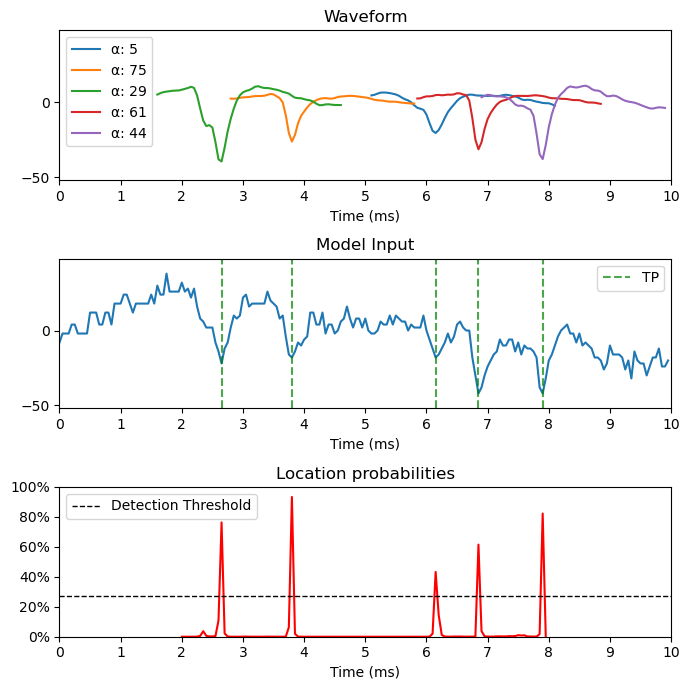

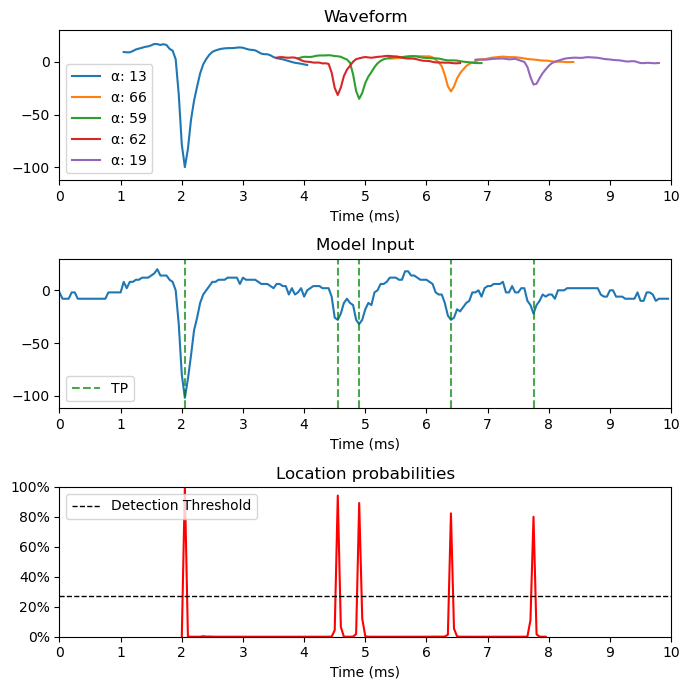

2954: Loss: 8.954 | WF Detected: 76.1% | Accuracy: 98.9% | Recall: 75.4% | Precision: 99.0% | F1 Score: 85.6% | Loc MAD: 0.22 frames = 0.0112 ms


'2954: Loss: 8.954 | WF Detected: 76.1% | Accuracy: 98.9% | Recall: 75.4% | Precision: 99.0% | F1 Score: 85.6% | Loc MAD: 0.22 frames = 0.0112 ms'

In [17]:
rec, train, val = cross_val["2954"]
perf = model.perf(val, plot_preds=("correct"))
model.perf_report("2954", perf)

## Old 
So old I don't remember

In [45]:
%load_ext autoreload
%autoreload

# Update PATH to allow imports
import sys
if "/data/MEAprojects/DLSpikeSorter" not in sys.path:
    sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
import numpy as np
import torch
from src.data import RecordingCrossVal, Recording
from src.model import ModelSpikeSorter
from src.utils import random_seed
from src.plot import set_ticks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Load recording cross val
%autoreload 3
rec_cross_val = RecordingCrossVal(sample_size=200, front_buffer=40, end_buffer=40,
                                  num_wfs_probs=[0.6, 0.24, 0.12, 0.04], isi_wf_min=5, isi_wf_max=None,
                                  thresh_amp=3, thresh_std=0.6,
                                  samples_per_waveform=20,
                                  device="cpu", mmap_mode="r",
                                  batch_size=1)

In [7]:
# Load single recording
rec, train, val = rec_cross_val["2950"]

In [ ]:
# Plot some samples
NUM_PLOTS = 1
random_seed(243)
##
dataset = val.dataset
for i in range(0, len(dataset), 2):
    # trace, num_wfs, wf_trace_locs, wf_alphas = dataset[i]
    dataset.plot_sample(*dataset[i])

In [8]:
## Load model
model = ModelSpikeSorter.load(f"/data/MEAprojects/DLSpikeSorter/models/v0_4_4/{rec}")
model = model.to("cpu")

In [ ]:
## Run model on val data and look at results
random_seed(105)
model.perf(train, plot_preds="noise")

In [9]:
## Get recording of noise
spike_times = np.load(f"/data/MEAprojects/DLSpikeSorter/{rec}/sorted.npz", allow_pickle=True)["spike_times"]
recording = Recording(rec_path=f"/data/MEAprojects/DLSpikeSorter/{rec}/data.raw.npy",
                      sample_size=200, start=0,
                      spike_times=spike_times,
                      mmap_mode="r")

In [37]:
# Run model on noise
N_SAMPLES = 10000
##
import torch
random_seed(231)
noises = []
for _ in range(N_SAMPLES):
    noise = torch.tensor(recording.get_sample(), dtype=torch.float32, device="cpu")
    noise -= torch.mean(noise)
    noises.append(noise[None, :])
noises = torch.stack(noises, dim=0)

Using random seed 231


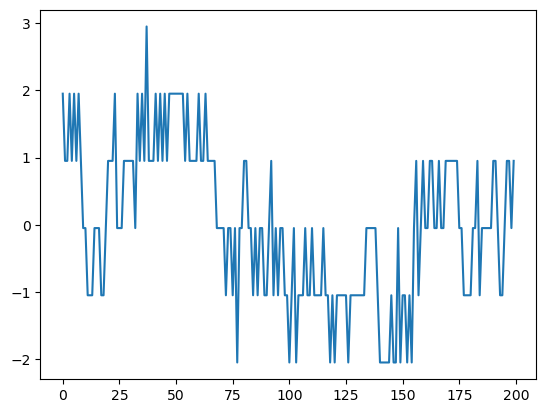

In [38]:
import matplotlib.pyplot as plt
plt.plot(noises[0, 0].numpy())
plt.show()

In [39]:
outputs = model(noises).detach()

In [40]:
preds = model.outputs_to_preds(outputs)

In [41]:
## Count number of false positives
num_fp = sum(p.size for p in preds)
print(f"Number of false positives/num samples: {num_fp}/{N_SAMPLES} = {num_fp/N_SAMPLES * 100:.2f}%")

Number of false positives/num samples: 252/10000 = 2.52%


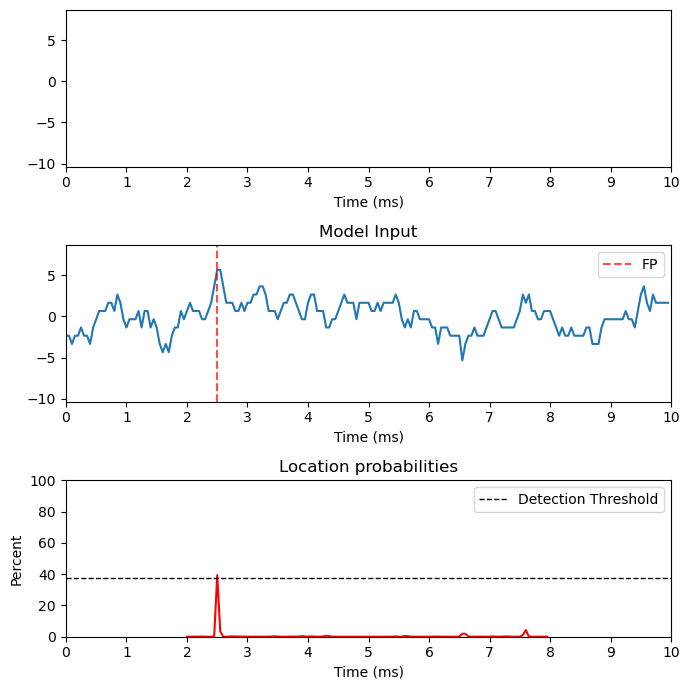

In [43]:
## Look at false positives
for noise, output, pred in zip(noises, outputs, preds):
    if pred.size == 0:
        continue
    model.plot_pred(noise, output, pred, num_wf=0, wf_labels=[], wf_alphas=[])
    break

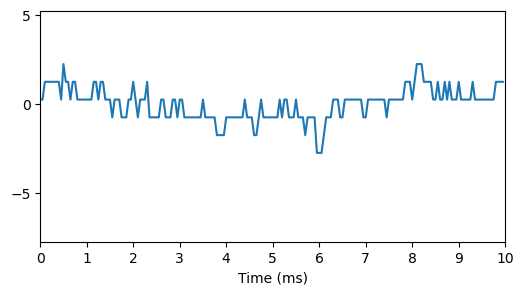

In [49]:
ST = 3523683
CHAN = 835
trace = recording[CHAN, ST-120: ST+80]
trace = trace - np.mean(trace)

fig, a0 = plt.subplots(1, figsize=(6, 3))
set_ticks((a0,), trace)
a0.plot(trace)
plt.show()

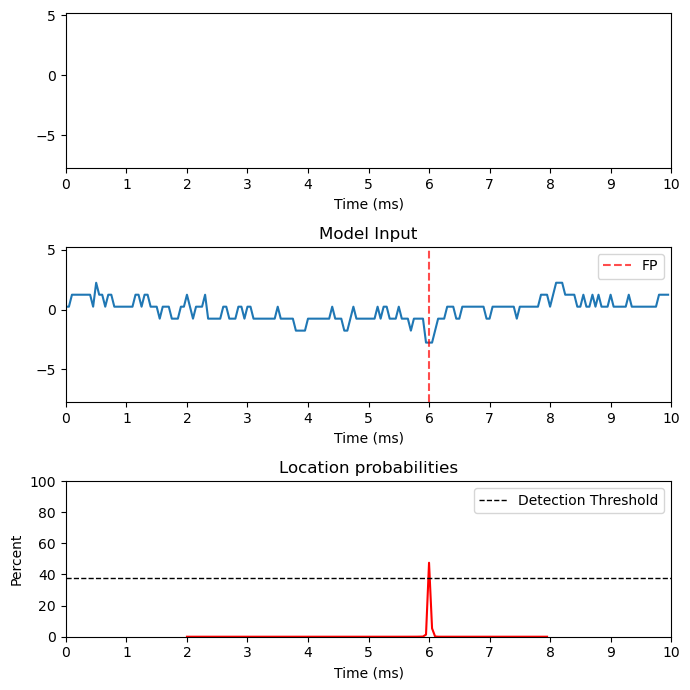

In [59]:
trace_tensor = torch.tensor(trace, dtype=torch.float32, device="cpu")[None, None, :]
output = model(trace_tensor).detach()
pred = model.outputs_to_preds(output)
model.plot_pred(trace_tensor.numpy().flatten(), output[0], pred[0], 0, [], [])

In [58]:
pred

[array([120])]